In [53]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import cmasher as cmr
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, add_pulsations, evaluate_pulsations, reset_pulsations
from spice.plots import plot_3D
from transformer_payne import Blackbody

import matplotlib
%matplotlib inline

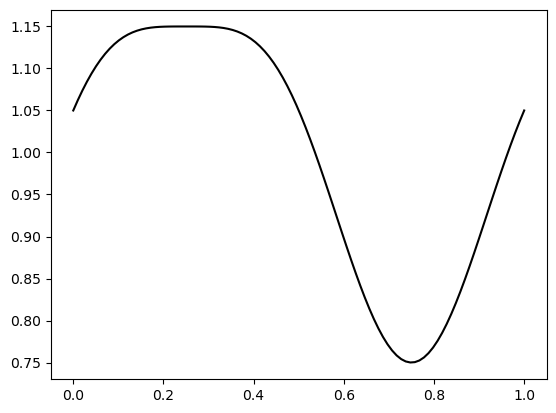

In [54]:
t = np.linspace(0, 1, 100)
f = 1+0.1*(2*jnp.sin(2*np.pi*t)+0.5*jnp.cos(4*np.pi*t))
plt.plot(t, f, color='black')

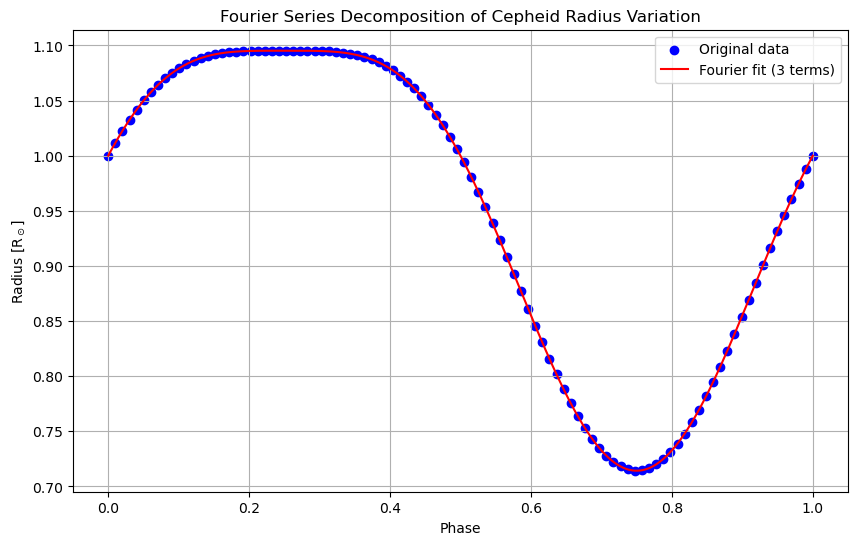

Mean radius (a0): 0.9524 R_sun
Fourier coefficients:
Term 1: amplitude = 0.1905, phase = 1.5708 rad
Term 2: amplitude = 0.0476, phase = -0.0000 rad
Term 3: amplitude = 0.0000, phase = 1.8607 rad

Fourier series parameters for SPICE:
[[ 1.90476196e-01  1.57079628e+00]
 [ 4.76190393e-02 -1.37034899e-07]
 [ 8.86823187e-09  1.86072564e+00]]


In [55]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

phases = np.array(t)
radius = np.array(f) / float(f[0])

# Define the Fourier series function
def fourier_series(x, a0, *args):
    """
    Fourier series function with a0 as the mean and args as pairs of (a_n, b_n) coefficients.
    """
    n_terms = len(args) // 2
    result = a0
    for i in range(n_terms):
        a_i = args[2*i]
        b_i = args[2*i+1]
        result += a_i * np.cos(2 * np.pi * (i+1) * x) + b_i * np.sin(2 * np.pi * (i+1) * x)
    return result

# Fit the Fourier series to the radius data
n_terms = 3
initial_guess = [np.mean(radius)] + [0.0] * (2 * n_terms)
params, params_covariance = optimize.curve_fit(fourier_series, phases, radius, p0=initial_guess, maxfev=10000)

# Extract the fitted parameters
a0 = params[0]
fourier_coeffs = params[1:]

# Prepare for visualization
phase_fine = np.linspace(0, 1, 1000)
radius_fit = fourier_series(phase_fine, *params)

# Plot the original data and the Fourier fit
plt.figure(figsize=(10, 6))
plt.scatter(phases, radius, color='blue', label='Original data')
plt.plot(phase_fine, radius_fit, color='red', label=f'Fourier fit ({n_terms} terms)')
plt.xlabel('Phase')
plt.ylabel('Radius [R$_\\odot$]')
plt.title('Fourier Series Decomposition of Cepheid Radius Variation')
plt.legend()
plt.grid(True)
plt.show()

# Print the Fourier coefficients
print(f"Mean radius (a0): {a0:.4f} R_sun")
print("Fourier coefficients:")
for i in range(n_terms):
    a_i = fourier_coeffs[2*i]
    b_i = fourier_coeffs[2*i+1]
    amplitude = np.sqrt(a_i**2 + b_i**2)
    phase = np.arctan2(b_i, a_i)
    print(f"Term {i+1}: amplitude = {amplitude:.4f}, phase = {phase:.4f} rad")

# Convert to format needed for SPICE pulsation model
# For SPICE, we need [amplitude, phase] pairs
fourier_series_parameters = np.zeros((n_terms, 2))
for i in range(n_terms):
    a_i = fourier_coeffs[2*i]
    b_i = fourier_coeffs[2*i+1]
    amplitude = np.sqrt(a_i**2 + b_i**2)
    phase = np.arctan2(b_i, a_i)
    fourier_series_parameters[i] = [amplitude, phase]

print("\nFourier series parameters for SPICE:")
print(fourier_series_parameters)

In [56]:
# Represent a sin function of period 0.4 days and amplitude 0.055 as a Fourier series for SPICE

# Define the period and amplitude
period3 = 0.2
amplitude3 = 0.15  # Match the amplitude scale of the previous cell (5% of 1.1 R_sun)

# For a pure sine: y = amplitude * sin(2*pi*phase)
# This is equivalent to a Fourier series with a1 = 0, b1 = amplitude, all other coefficients zero
# So amplitude = sqrt(a1^2 + b1^2) = amplitude3, phase = arctan2(b1, a1) = arctan2(amplitude3, 0) = pi/2

n_terms = 3  # match the number of terms as before
fourier_series_parameters3 = np.zeros((n_terms, 2))
# Only the first term is nonzero
fourier_series_parameters3[0] = [amplitude3, np.pi/2]

print(f"Sin function (period={period3} days, amplitude={amplitude3}) as Fourier series parameters for SPICE:")
print(fourier_series_parameters3)


Sin function (period=0.2 days, amplitude=0.15) as Fourier series parameters for SPICE:
[[0.15       1.57079633]
 [0.         0.        ]
 [0.         0.        ]]


In [57]:
jnp.concatenate([fourier_series_parameters, fourier_series_parameters3])

Array([[ 1.9047619e-01,  1.5707963e+00],
       [ 4.7619041e-02, -1.3703490e-07],
       [ 8.8682315e-09,  1.8607256e+00],
       [ 1.5000001e-01,  1.5707964e+00],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00]], dtype=float32)

total_pad_len: 2


/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


Text(0.5, 0.92, 'Radial pulsation (m=0, l=0)\nPeriod=0.2 days, Amplitude=5%')

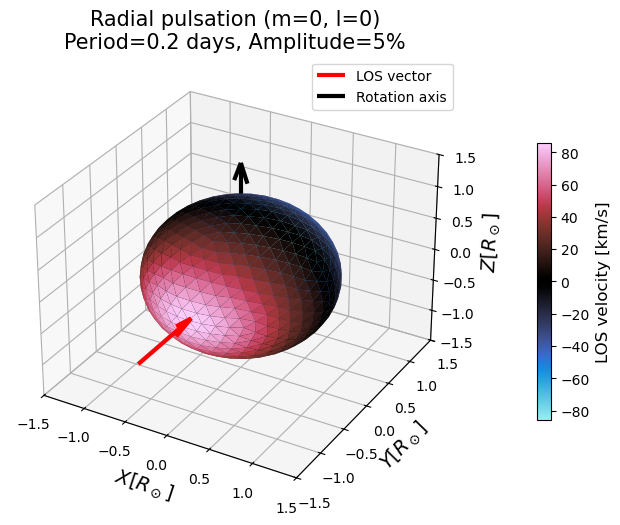

In [58]:
bb = Blackbody()
m = IcosphereModel.construct(1000, 1., 1., bb.to_parameters(), bb.parameter_names)

EV_TIME = 0.5

# Create a 2x2 grid of pulsation configurations
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

m_pulsation1_ev = add_pulsations(
    m,
    m_orders=jnp.array([0, 2]),
    l_degrees=jnp.array([0, 2]),
    periods=jnp.array([0.2, 0.2]),
    fourier_series_parameters=jnp.stack([fourier_series_parameters, fourier_series_parameters3])
)

m_pulsation11 = add_pulsation(
    m,
    m_order=jnp.array([0]),
    l_degree=jnp.array([0]),
    period=jnp.array([0.2]),
    fourier_series_parameters=fourier_series_parameters
)

m_pulsation12 = add_pulsation(
    m,
    m_order=jnp.array([2]),
    l_degree=jnp.array([2]),
    period=jnp.array([0.2]),
    fourier_series_parameters=fourier_series_parameters3
)

m_pulsation1 = evaluate_pulsations(m_pulsation1_ev, EV_TIME)
ax1 = plot_3D(m_pulsation1, property='los_velocities', axes=(fig, ax), property_label="LOS velocity [km/s]", cmap='cmr.redshift')
ax.set_title(f"Radial pulsation (m=0, l=0)\nPeriod=0.2 days, Amplitude=5%", fontsize=15)

In [59]:
def calculate_mean_rad_vel(model):
    # Calculate the magnitude of velocity vectors
    velocity_magnitudes = np.sqrt(model.pulsation_velocities[:, 0]**2 + model.pulsation_velocities[:, 1]**2 + model.pulsation_velocities[:, 2]**2)
    
    # Determine sign based on radial component (negative = contracting, positive = expanding)
    # For a spherical model, we can use the dot product with normalized position vectors
    normalized_positions = model.centers / np.linalg.norm(model.centers, axis=1)[:, np.newaxis]
    radial_components = np.sum(model.pulsation_velocities * normalized_positions, axis=1)
    
    # Apply sign to magnitudes
    signed_velocities = np.sign(radial_components) * velocity_magnitudes
    return signed_velocities

In [60]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d
cmap = 'cmr.redshift'

def plot_mesh_frame(model, plot_ax, to_be_mapped, norm, mappable):
    # Set up axes limits and labels
    axes_lim = 1.1*model.radius
    plot_ax.set_xlim3d(-axes_lim, axes_lim)
    plot_ax.set_ylim3d(-axes_lim, axes_lim)
    plot_ax.set_zlim3d(-axes_lim, axes_lim)
    plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
    plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
    plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)
    vs2 = model.mesh_elements
    if norm and mappable:
        face_colors = mpl.colormaps[cmap](norm(to_be_mapped))
    else:
        face_colors = mpl.colormaps[cmap](to_be_mapped)
    p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black", linewidths=0.01)
    plot_ax.add_collection(p)
    if norm and mappable:
        mappable.set_array([])
        
    return fig, plot_ax

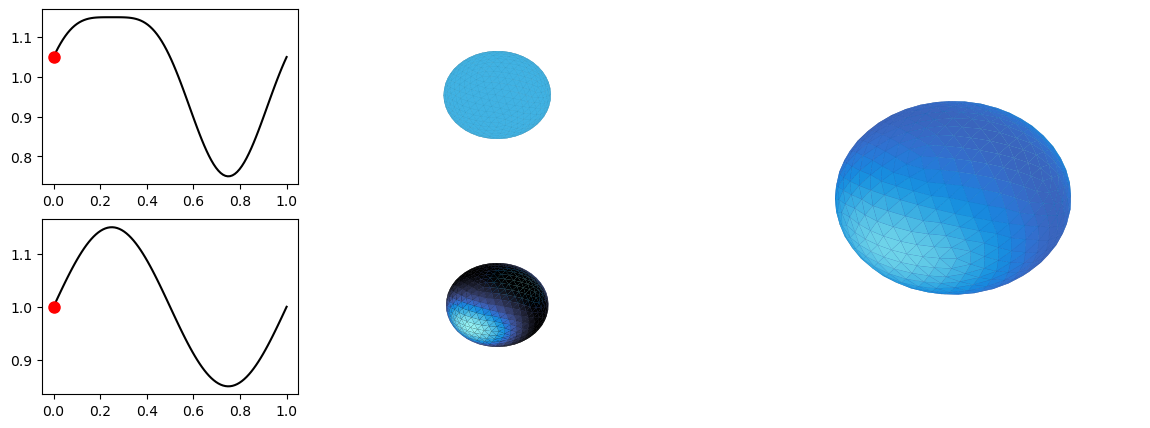

In [61]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from spice.models.utils import evaluate_fourier_for_value
_t = t
_f = f

_f3 = [1+evaluate_fourier_for_value(
    1.0,
    jnp.array([fourier_series_parameters3[:, 0]]),
    jnp.array([fourier_series_parameters3[:, 1]]),
    __t
) for __t in _t]

# Set up the figure: 1 row, 3 columns (function1, function2, mesh)
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 2])

# Left column: two stacked axes for the functions
ax_func1 = fig.add_subplot(gs[0, 0])
ax_func2 = fig.add_subplot(gs[1, 0])

# Right column: one big axis spanning both rows for the main plot
ax_big = fig.add_subplot(gs[:, 2], projection='3d')

ax_mesh_1 = fig.add_subplot(gs[0, 1], projection='3d')
ax_mesh_2 = fig.add_subplot(gs[1, 1], projection='3d')
ax_mesh_1.axis('off')
ax_mesh_2.axis('off')
ax_big.axis('off')


ax_func1.plot(_t, _f, color='black');
ax_func2.plot(_t, _f3, color='black');

# Animate a dot showing the current amplitude in the left column

from matplotlib.animation import FuncAnimation

# We'll animate a red dot on ax_func1 to show the current amplitude
dot1, = ax_func1.plot([_t[0]], [_f[0]], 'ro', markersize=8)
dot2, = ax_func2.plot([_t[0]], [_f3[0]], 'ro', markersize=8)

# We'll animate the 3D plot as well as the function dots

# Store the mesh and plot objects for each frame
from spice.models.mesh_transform import evaluate_pulsations

# Precompute all meshes for each time step for efficiency
meshes = [evaluate_pulsations(m_pulsation1_ev, __t) for __t in 0.2*_t]
meshes1 = [evaluate_pulsations(m_pulsation11, __t) for __t in 0.2*_t]
meshes2 = [evaluate_pulsations(m_pulsation12, __t) for __t in 0.2*_t]

mesh_vels = np.array([calculate_mean_rad_vel(m) for m in meshes])
mesh_vels1 = np.array([calculate_mean_rad_vel(m) for m in meshes1])
mesh_vels2 = np.array([calculate_mean_rad_vel(m) for m in meshes2])

all_mesh_vels = jnp.array([mesh_vels, mesh_vels1, mesh_vels2]).flatten()

# We'll keep a reference to the Poly3DCollection so we can update it
# We'll use the first mesh to initialize

# Define a single constant colormap to use throughout
constant_cmap = 'cmr.redshift'

minmax = np.array([-1, 1])

# Set up colormap
norm = mpl.colors.Normalize(vmin=all_mesh_vels.min(), vmax=all_mesh_vels.max())
mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

norm1 = mpl.colors.Normalize(vmin=mesh_vels1.min(), vmax=mesh_vels1.max())
mappable1 = mpl.cm.ScalarMappable(cmap=cmap, norm=norm1)

norm2 = mpl.colors.Normalize(vmin=mesh_vels2.min(), vmax=mesh_vels2.max())
mappable2 = mpl.cm.ScalarMappable(cmap=cmap, norm=norm2)

# Plot the initial mesh and keep the Poly3DCollection references so we can update them
# FIX: plot_mesh_frame returns (fig, ax), but we want the Poly3DCollection object
def get_poly3dcollection_from_ax(ax):
    # Return the last Poly3DCollection added to the axis
    for obj in reversed(ax.collections):
        if isinstance(obj, art3d.Poly3DCollection):
            return obj
    raise RuntimeError("No Poly3DCollection found in axis.")

plot_mesh_frame(meshes[0], ax_big, mesh_vels[0], norm, mappable)
plot_mesh_frame(meshes1[0], ax_mesh_1, mesh_vels1[0], norm1, mappable1)
plot_mesh_frame(meshes2[0], ax_mesh_2, mesh_vels2[0], norm2, mappable2)

mesh_plot = get_poly3dcollection_from_ax(ax_big)
mesh_plot1 = get_poly3dcollection_from_ax(ax_mesh_1)
mesh_plot2 = get_poly3dcollection_from_ax(ax_mesh_2)

def update_all(frame):
    # Update function dots
    dot1.set_data([_t[frame]], [_f[frame]])
    dot2.set_data([_t[frame]], [_f3[frame]])
    # Instead of re-calling plot_mesh_frame (which may add new collections and cause black plots),
    # update the existing Poly3DCollection objects in-place
    def update_mesh_plot(mesh, mesh_vel, mesh_plot, norm, mappable):
        # mesh_plot is a Poly3DCollection
        # mesh is the mesh object for this frame
        # mesh_vel is the array of velocities for this frame
        # Update the vertices
        mesh_plot.set_verts(mesh.mesh_elements)
        # Update the face colors if needed
        if norm is not None and mappable is not None:
            face_colors = mpl.colormaps[cmap](norm(mesh_vel))
            mesh_plot.set_facecolor(face_colors)
        else:
            # fallback: use default colormap
            face_colors = mpl.colormaps[cmap](mesh_vel)
            mesh_plot.set_facecolor(face_colors)
        return mesh_plot

    update_mesh_plot(meshes[frame], mesh_vels[frame], mesh_plot, norm, mappable)
    update_mesh_plot(meshes1[frame], mesh_vels1[frame], mesh_plot1, norm1, mappable1)
    update_mesh_plot(meshes2[frame], mesh_vels2[frame], mesh_plot2, norm2, mappable2)
    return (dot1, dot2, mesh_plot, mesh_plot1, mesh_plot2)

# Set up the animation: animate over the length of t
ani = FuncAnimation(
    fig, update_all, frames=len(_t), interval=50, blit=False
)


In [62]:
ani.save('amplitude_animation2.gif', writer='pillow')

In [63]:
mesh_vels2.shape

(100, 1280)

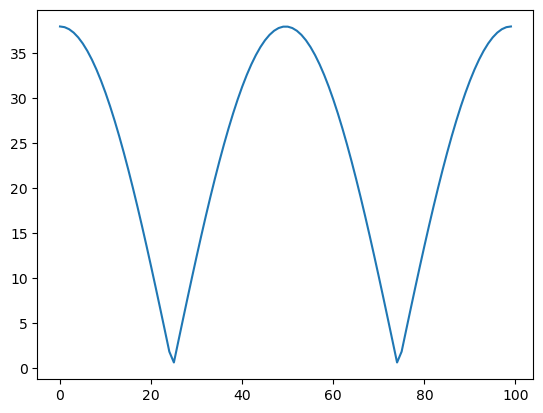

In [64]:
plt.plot(np.max(np.abs(mesh_vels2), axis=1))

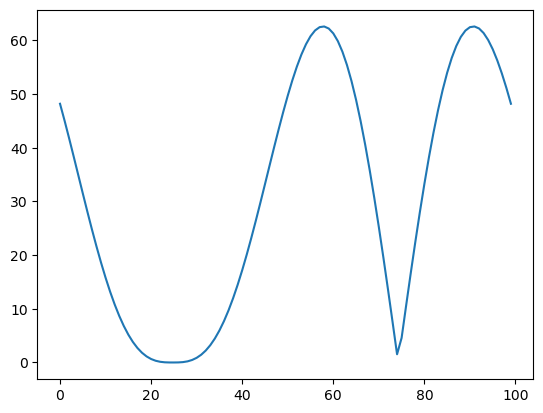

In [65]:
plt.plot(np.max(np.abs(mesh_vels1), axis=1))